In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys

In [2]:
# Reset modules you've made changes to

import xbmodeling.gen_model as gm
import xbmodeling.pointing_model as pnt
from xbmodeling.config import modelconf
from xbmodeling.config import mountconf
del sys.modules['xbmodeling.gen_model']
del sys.modules['xbmodeling.config']
del sys.modules['xbmodeling.pointing_model']
import xbmodeling.gen_model as gm
import xbmodeling.pointing_model as pnt
from xbmodeling.config import modelconf
from xbmodeling.config import mountconf

### Generative Model

The module `gen_model` is responsible for taking telescope scans and ultimately returning simulations of per-pixel timestreams. It loads the CMB maps, generates background and beam maps, and handles the convolution and reobservation of these maps. All of this functionality is packed into the `GenModelMap` Class, which we'll discuss in a bit. Some examples on how the map-making subfunctions are used is below:

/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=128
Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin



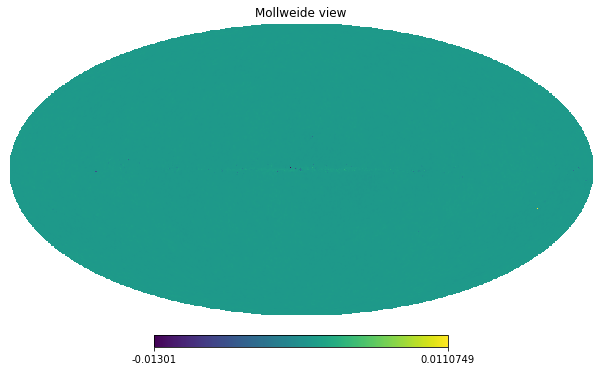

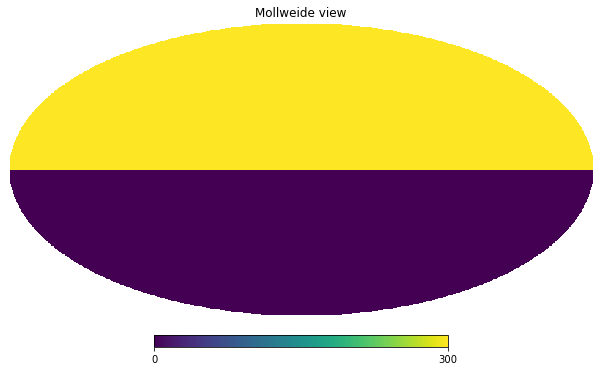

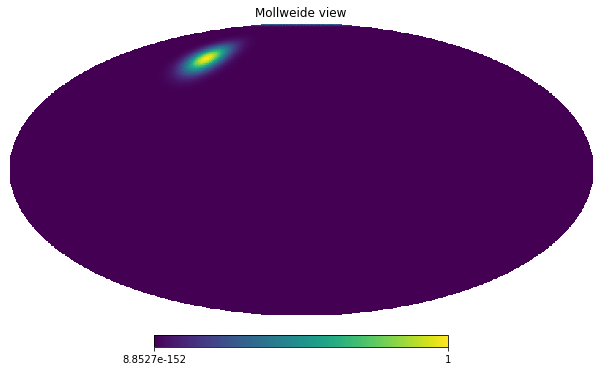

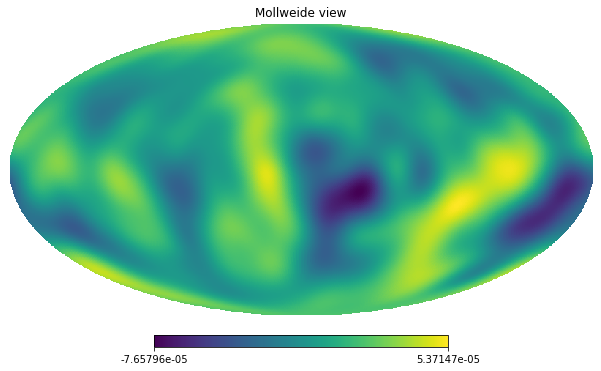

In [3]:
# Example usage of the gen_model subfunctions:
# Extract some CMB map. Lower the resolution so that it doesn't take forever
nside = 128
cmbmap = gm.make_cmb_map(modelconf["cmbFile"], nside_out=nside)

## Make a background map of 300K
groundmap = gm.make_ground_template(300,nside)

## Make a beammap made of a main beam and an 'extended' beam.
beammap = gm.make_beam_map(params = [1,0,0,3,3,1],nside=nside)
beammap2 = gm.make_beam_map(params =[0.5,0,30,30,30,0],nside=nside)
bm_total = (beammap+beammap2)/np.max(beammap+beammap2) # Add and normalize

# Convolve the maps together, Leave out the background so we can see the effect on the CMB
conv_map = gm.convolve_maps(cmbmap[0,:],bm_total)

# Plot the different maps
hp.mollview(cmbmap[0,:])
hp.mollview(groundmap)
hp.mollview(bm_total)
hp.mollview(conv_map)

print()

### Pointing Model
The other important module is called `pointing_model`. Given from telescope pointing information from the data and telescope focal plane information, this will tell us the _apparent_ pointing for a given detector. This also handles per-detector polarization orientations. As now, it can handle timestreams from a single detector. That is, `az,el,dk,time` can be scalars or numpy arrays, but `r` and `theta` should be scalar.

Lastly, telescope information is built into the configuration file `config.py` under the `mountconf` dictionary. Currently, only Keck and BICEP3 are included.

In [4]:
# pnt.beam_pointing_model(az, el, dk, r, theta,pol=0, mnt=mountconf["keck"])
az = np.zeros(3)
el = np.zeros(3)
dk = np.zeros(3)
r = 0
theta = 0

az_app, el_app, pa = pnt.beam_pointing_model(az, el, dk, r, theta,pol=0,mntstr="B3")
print(az_app,el_app,pa)

[0. 0. 0.] [3.50835465e-15 3.50835465e-15 3.50835465e-15] [180. 180. 180.]


### The GenModelMap class function:
```
GenModelMap(cmb_file=modelconf["cmbFile"],
   T=modelconf["groundTemperature"],
   nside=modelconf["defaultResolution"],
   main_beam_params_A=None,
   main_beam_params_B=None, 
   ext_beam_params=None
   )
```
This class holds and handles all of the model information (i.e. CMB, beammaps, etc.) which are informed by various inputs such a the detector pointing. 

In [5]:
model = gm.GenModelMap(nside=nside)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


Current map NSIDE=512. Converting to NSIDE=128
Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Uninitialized, the class produces a delta function for the beammap so that the convolution map will simply be the CMB+background map.

It also has the ability to plot the maps is holds:

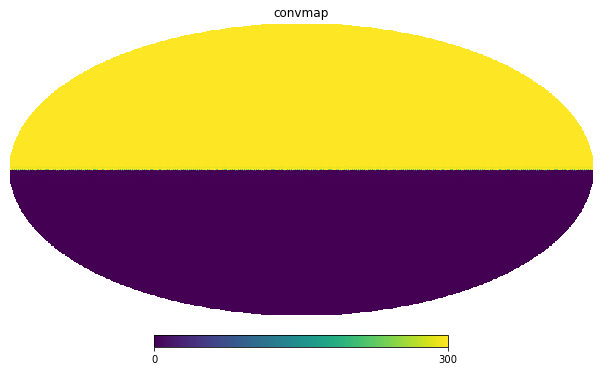

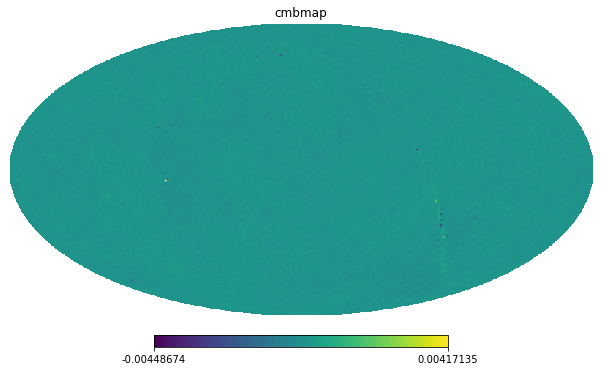

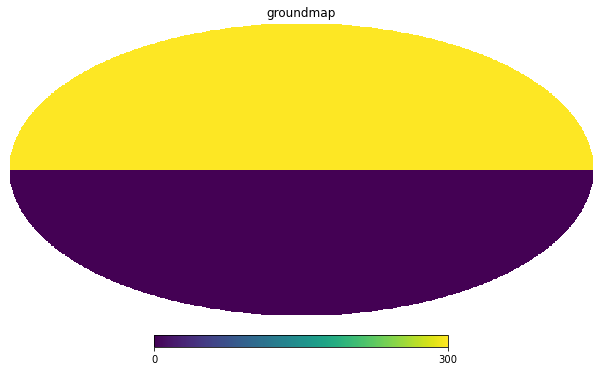

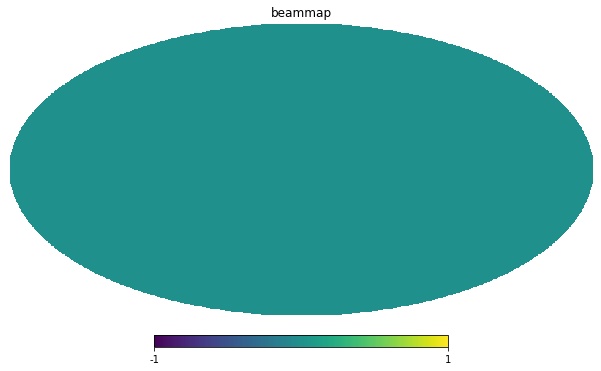

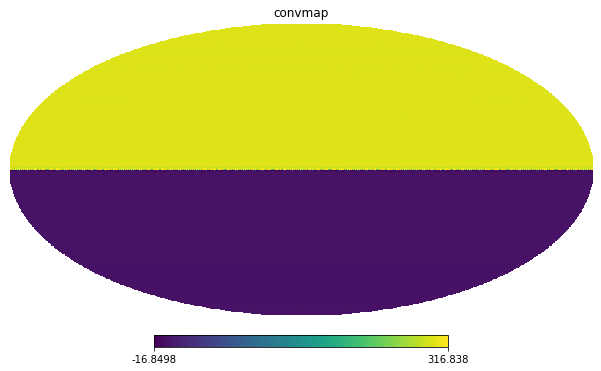

In [6]:
model.plot('convmap',min=0,max=300)
model.plot('all')

Combined with the pointing model, we can extract timestreams for a detector by telling the model to observe the maps.

CPU times: user 171 ms, sys: 3.64 ms, total: 175 ms
Wall time: 779 ms


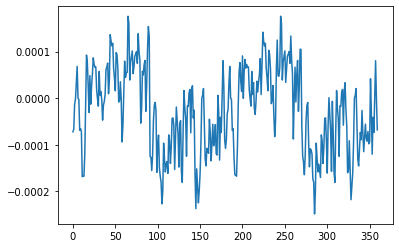

In [7]:
az = np.arange(360)
el = np.zeros(360)+55
dk = np.zeros(360)
time = np.zeros(360)+5.5e5#np.arange(10)
#print(el)
%time simdata = model.observe(az,el,dk,time)
#model.plot("groundmap")

plt.figure(3)
plt.plot(az,simdata)

For troubleshooting, we can look at where the observation was:

CPU times: user 518 ms, sys: 14.9 ms, total: 533 ms
Wall time: 889 ms


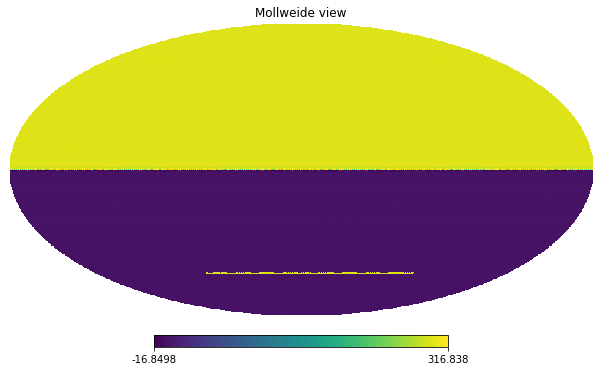

In [8]:
%time simdata = model.observe(az,el,dk,time,showplot=True)

Lastly, instead of making a new instance of the model and having to load and create all of the maps again, we can tell the model to regenerate only the parts we want to change. For instance, if we want to change the beam width of the extended beam, only the extended beam map is reproduced:

Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


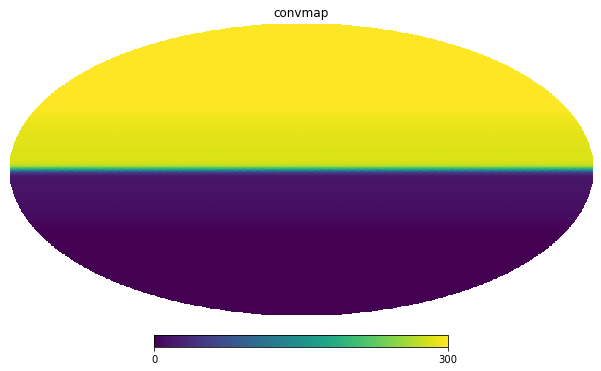

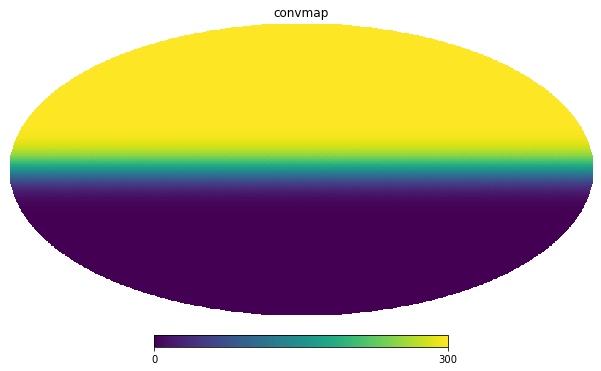

In [9]:
model.regen_model(extended=[1,30,0,1,1,1])
model.plot('convmap',min=0,max=300)
model.regen_model(extended=[1,30,0,30,30,1])
model.plot('convmap',min=0,max=300)